In [1]:
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

os.makedirs('./images/gan', exist_ok=True)

In [2]:
np.random.seed(1234)
torch.manual_seed(1234)
random.seed(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
BATCH_SIZE  = 64
N_EPOCHS = 100
IMAGE_SIZE = 28 * 28
LATENT_DIM = 100
PRINT_EVERY = 5
N_SHOW = 5

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

In [ ]:
data = datasets.MNIST('.data', 
                        train=True, 
                        download=True, 
                        transform=transforms,
                        )

In [ ]:
iterator = DataLoader(data,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      drop_last=True,
                     )

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, image_size):
        super().__init__()
        
        self.main = nn.Sequential(
            
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            
            nn.Linear(1024, image_size),
            nn.Tanh(),
  
        )
        
    def forward(self, x):
        return self.main(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        
        self.main = nn.Sequential(
        
            nn.Linear(image_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(256, 1),
            nn.Sigmoid(),
            
        )
        
    def forward(self, x):
        return self.main(x).squeeze(1)

In [ ]:
G = Generator(LATENT_DIM, IMAGE_SIZE).to(device)

In [ ]:
D = Discriminator(IMAGE_SIZE).to(device)

In [ ]:
criterion = nn.BCELoss()

In [ ]:
G_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
#labels
real_labels = torch.ones(BATCH_SIZE,).to(device)
fake_labels = torch.zeros(BATCH_SIZE,).to(device)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

| Epoch: 005 | D_error: 1.031 | G_error: 2.039 | Time: 1m 3s


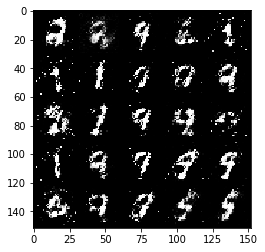

| Epoch: 010 | D_error: 0.898 | G_error: 1.467 | Time: 1m 2s


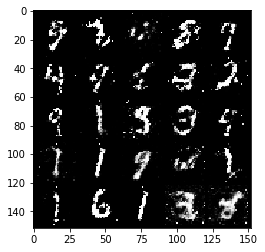

| Epoch: 015 | D_error: 1.056 | G_error: 1.534 | Time: 1m 22s


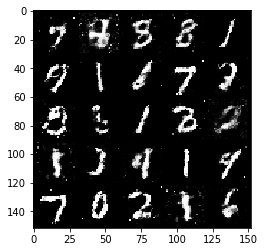

In [ ]:
for epoch in range(1, N_EPOCHS+1):
    
    start_time = time.time()
    
    for _ in range(len(iterator)):

        #=====================#
        # TRAIN DISCRIMINATOR #
        #=====================#
        
        #zero discriminator gradients
        D.zero_grad()
        
        #get batch of real images
        x, _ = next(iter(iterator))
        
        #place images on GPU 
        x = x.to(device)
        
        #flatten images
        x = x.view(-1, IMAGE_SIZE)
        
        #sample noise
        z = torch.randn(x.shape[0], LATENT_DIM).to(device)
        
        #generate images
        with torch.no_grad():
            generated_images = G(z)
        
        #put real images through discriminator
        pred_real = D(x)
        
        #how well does the discriminator detect real images?
        D_error_real = criterion(pred_real, real_labels)
        
        #put fake images through the discriminator
        #need to detach so don't backpropagate through generator
        pred_fake = D(generated_images.detach())
        
        #how well does the discriminator detect fake images?
        D_error_fake = criterion(pred_fake, fake_labels)
        
        #get discriminator error
        D_error = D_error_real + D_error_fake
        
        #backpropagate errors to get gradients
        D_error.backward()
        
        #use gradient to update discriminator parameters
        D_optimizer.step()
        
        #=================#
        # TRAIN GENERATOR #
        #=================#
        
        #zero generator gradients
        G.zero_grad()
        
        #get batch of real images
        x, _ = next(iter(iterator))
        
        #place images on GPU 
        x = x.to(device)
        
        #flatten images
        x = x.view(-1, IMAGE_SIZE)
        
        #sample noise
        z = torch.randn(x.shape[0], LATENT_DIM).to(device)
        
        #generate images
        generated_images = G(z)
        
        #put fake images through the discriminator
        pred_fake = D(generated_images)
        
        #how well does the generator fool the discriminator?
        G_error = criterion(pred_fake, real_labels)
        
        #backpropagate errors to get gradients
        G_error.backward()
        
        #use gradient to update generator parameters
        G_optimizer.step()
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if (epoch % PRINT_EVERY) == 0:

        #sample noise
        z = torch.randn(N_SHOW*N_SHOW, LATENT_DIM).to(device)
        
        #generate images
        with torch.no_grad():
            generated_images = G(z)
        
        #reshape to (batch, channel, height, width)
        generated_images = generated_images.view(-1, 1, 28, 28)
        
        print(f'| Epoch: {epoch:03} | D_error: {D_error.item():.03f} | G_error: {G_error.item():.03f} | Time: {epoch_mins}m {epoch_secs}s')
        
        #save N_SHOW*N_SHOW images
        torchvision.utils.save_image(generated_images, 
                                     f'images/gan/epoch{epoch:03}.png', 
                                     nrow=N_SHOW, 
                                     normalize=True)
        
        #display images
        img = plt.imread(f'images/gan/epoch{epoch:03}.png')
        plt.imshow(img)
        plt.show()